<a href="https://colab.research.google.com/github/NULabTMN/hw3-aidasharif1365/blob/master/ner_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Viterbi Decoder and Evaluation for Sequence Labeling

In this assignment, you will build a Viterbi decoder for an LSTM named-entity recognition model. As we mentioned in class, recurrent and bidirectional recurrent neural networks, of which LSTMs are the most common examples, can be used to perform sequence labeling. Although these models encode information from the surrounding words in order to make predictions, there are no "hard" constraints on what tags can appear where.

There hard constraints are particularly important for tasks that label spans of more than one token. The most common example of a span-labeling task is named-entity recognition (NER). As described in Eisenstein, Jurafksy & Martin, and other texts, the goal of NER is to label spans of one or more words as _mentions_ of an _entity_, such as a person, location, organization, etc.

The most common approach to NER is to reduce it to a sequence-labeling task, where each token in the input is labeled either with an `O`, if it is "outside" any named-entity span, or with `B-TYPE`, if it is the first token in an entity of type `TYPE`, or with `I-TYPE`, if it is the second or later token in an entity of type `TYPE`. Distinguishing between the first and later tokens of an entity allow us to identify distinct entity spans even when they are adjacent.

Common values of `TYPE` include `PER` for person, `LOC` for location, `DATE` for date, and so on. In the dataset we load below, there are 17 distinct types.

The span-labeling scheme just described implies that the labels on tokens must obey certain constraints: the tag `I-PER` must follow either `B-PER` or another `I-PER`. It cannot follow `O`, `B-LOC`, or `I-LOC`, i.e., a tag for a different entity type. By themselves, LSTMs or bidirectional LSTMs cannot directly enforce these constraints. This is one reason why conditional random fields (CRFs), which _can_ enforce these constraints, are often layered on top of these recurrent models.

In this assignment, you will implement the simplest possible CRF: a CRF so simple that it does not require any training. Rather, it will assign weight 1 to any sequence of tags that obeys the constraints and weight 0 to any sequence of tags that violates them. The inputs to the CRF, which are analogous to the emission probabilities in an HMM, will come from an LSTM.

But first, in order to test your decoder, you will also implement some functions to evaluate the output of an NER system according to two metrics:
1. You will count the number of _violations_ of the NER label constraints, i.e., how many times `I-TYPE` follows `O` or a tag of a different type or occurs at the beginning of a sentence. This number will be greater than 0 in the raw LSTM output, but should be 0 for your CRF output.
1. You will compute the _span-level_ precision, recall, and F1 of NER output. Although the baseline LSTM was trained to achieve high _token-level_ accuracy, this metric can be misleadingly high, since so many tokens are correctly labeled `O`. In other words, what proportion of spans predicted by the model line up exactly with spans in the gold standard, and what proportion of spans in the gold standard were predicted by the model? Define _span_ as a sequence of tags that starts with a `B-TYPE` followed by zero or more `I-TYPE` tags. Sequences solely of `I-TYPE` tags don't count as spans.For more, see the original task definition: https://www.aclweb.org/anthology/W03-0419/.

We start with loading some code and data and the describe your tasks in more detail.

## Set Up Dependencies and Definitions

In [1]:
!pip install --upgrade spacy==2.1.0 allennlp==0.9.0
import spacy

     |████████████████████████████████| 27.7MB 117kB/s 
     |████████████████████████████████| 7.6MB 19.0MB/s 
     |████████████████████████████████| 2.1MB 51.7MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 3.2MB 45.7MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 5.6MB 42.6MB/s 
     |████████████████████████████████| 245kB 56.0MB/s 
     |████████████████████████████████| 163kB 43.0MB/s 
     |████████████████████████████████| 266kB 54.1MB/s 
     |████████████████████████████████| 317kB 51.6MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 133kB 55.6MB/s 
     |████████████████████████████████| 7.3MB 42.5MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 256kB 56.5MB/s 

In [2]:
from typing import Iterator, List, Dict
import torch
import torch.optim as optim
import numpy as np
from allennlp.data import Instance
from allennlp.data.fields import TextField, SequenceLabelField
from allennlp.data.dataset_readers import DatasetReader
from allennlp.common.file_utils import cached_path
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token
from allennlp.data.vocabulary import Vocabulary
from allennlp.models import Model
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.seq2seq_encoders import Seq2SeqEncoder, PytorchSeq2SeqWrapper
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.data.iterators import BucketIterator
from allennlp.training.trainer import Trainer
from allennlp.predictors import SentenceTaggerPredictor
from allennlp.data.dataset_readers import conll2003

torch.manual_seed(1)

In [3]:
class LstmTagger(Model):
  def __init__(self,
               word_embeddings: TextFieldEmbedder,
               encoder: Seq2SeqEncoder,
               vocab: Vocabulary) -> None:
    super().__init__(vocab)
    self.word_embeddings = word_embeddings
    self.encoder = encoder
    self.hidden2tag = torch.nn.Linear(in_features=encoder.get_output_dim(),
                                      out_features=vocab.get_vocab_size('labels'))
    self.accuracy = CategoricalAccuracy()

  def forward(self,
              tokens: Dict[str, torch.Tensor],
              metadata,
              tags: torch.Tensor = None) -> Dict[str, torch.Tensor]:
    mask = get_text_field_mask(tokens)
    embeddings = self.word_embeddings(tokens)
    encoder_out = self.encoder(embeddings, mask)
    tag_logits = self.hidden2tag(encoder_out)
    output = {"tag_logits": tag_logits}
    if tags is not None:
      self.accuracy(tag_logits, tags, mask)
      output["loss"] = sequence_cross_entropy_with_logits(tag_logits, tags, mask)

    return output

  def get_metrics(self, reset: bool = False) -> Dict[str, float]:
    return {"accuracy": self.accuracy.get_metric(reset)}

## Import Data

In [4]:
reader = conll2003.Conll2003DatasetReader()
train_dataset = reader.read(cached_path('http://www.ccs.neu.edu/home/dasmith/onto.train.ner.sample'))
validation_dataset = reader.read(cached_path('http://www.ccs.neu.edu/home/dasmith/onto.development.ner.sample'))

from itertools import chain
vocab = Vocabulary.from_instances(chain(train_dataset, validation_dataset))

159377B [00:00, 48251450.02B/s]
562it [00:00, 19876.71it/s]
8366B [00:00, 21344006.85B/s]
23it [00:00, 4184.12it/s]
585it [00:00, 62146.49it/s]


## Define and Train Model

In [5]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                            embedding_dim=EMBEDDING_DIM)
word_embeddings = BasicTextFieldEmbedder({"tokens": token_embedding})
lstm = PytorchSeq2SeqWrapper(torch.nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, bidirectional=False, batch_first=True))
model = LstmTagger(word_embeddings, lstm, vocab)
if torch.cuda.is_available():
    cuda_device = 0
    model = model.cuda(cuda_device)
else:
    cuda_device = -1
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, eps=1e-8)
optimizer = optim.SGD(model.parameters(), lr=0.1)
iterator = BucketIterator(batch_size=2, sorting_keys=[("tokens", "num_tokens")])
iterator.index_with(vocab)
trainer = Trainer(model=model,
                  optimizer=optimizer,
                  iterator=iterator,
                  train_dataset=train_dataset,
                  validation_dataset=validation_dataset,
                  patience=10,
                  num_epochs=100,
                  cuda_device=cuda_device)
trainer.train()

accuracy: 0.8442, loss: 0.9047 ||: 100%|██████████| 281/281 [00:01<00:00, 196.23it/s]
accuracy: 0.7878, loss: 1.2029 ||: 100%|██████████| 12/12 [00:00<00:00, 380.83it/s]
accuracy: 0.8442, loss: 0.7296 ||: 100%|██████████| 281/281 [00:01<00:00, 260.74it/s]
accuracy: 0.7878, loss: 1.1897 ||: 100%|██████████| 12/12 [00:00<00:00, 394.88it/s]
accuracy: 0.8442, loss: 0.7158 ||: 100%|██████████| 281/281 [00:01<00:00, 239.58it/s]
accuracy: 0.7878, loss: 1.1900 ||: 100%|██████████| 12/12 [00:00<00:00, 351.43it/s]
accuracy: 0.8442, loss: 0.7066 ||: 100%|██████████| 281/281 [00:01<00:00, 244.84it/s]
accuracy: 0.7878, loss: 1.1669 ||: 100%|██████████| 12/12 [00:00<00:00, 454.91it/s]
accuracy: 0.8442, loss: 0.6988 ||: 100%|██████████| 281/281 [00:01<00:00, 252.79it/s]
accuracy: 0.7878, loss: 1.1730 ||: 100%|██████████| 12/12 [00:00<00:00, 368.55it/s]
accuracy: 0.8442, loss: 0.6910 ||: 100%|██████████| 281/281 [00:01<00:00, 261.73it/s]
accuracy: 0.7878, loss: 1.1639 ||: 100%|██████████| 12/12 [00:00

{'best_epoch': 96,
 'best_validation_accuracy': 0.8795918367346939,
 'best_validation_loss': 0.37943273926309,
 'epoch': 99,
 'peak_cpu_memory_MB': 3224.064,
 'peak_gpu_0_memory_MB': 1058,
 'training_accuracy': 0.9283974155280161,
 'training_cpu_memory_MB': 3224.064,
 'training_duration': '0:02:05.158952',
 'training_epochs': 99,
 'training_gpu_0_memory_MB': 1058,
 'training_loss': 0.1901172606272,
 'training_start_epoch': 0,
 'validation_accuracy': 0.8795918367346939,
 'validation_loss': 0.3810475505888462}

## Evaluation

The simple code below loops over the validation set, applying the model to each exmaple and collecting out the input token, gold-standard output, and model output. You can see from these methods how to access ground truth and model outputs for evaluation.

In [6]:
!pip install seqeval
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report

     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=2028a5c68bbdcfd7b1b4cf0315d49d86576d8f4ef893e65d986ade8ee469d303
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [7]:
def tag_sentence(s):
  tag_ids = np.argmax(model.forward_on_instance(s)['tag_logits'], axis=-1)
  fields = zip(s['tokens'], s['tags'], [model.vocab.get_token_from_index(i, 'labels') for i in tag_ids])
  return list(fields)

word_gold_real = [tag_sentence(i) for i in validation_dataset]

Now, you can implement two evaluation functions: `violations` and `span_stats`.

In [8]:
def valid_output(example):
  arr1=[]
  for i in example:
    arr1.append(i[2])
  return arr1

In [9]:
# TODO: count the number of NER label violations,
# such as O followed by I-TYPE or B-TYPE followed by
# I-OTHER_TYPE
# Take tagger output as input
import collections
def violations(tagged):
  count=0
  for i in range(len(tagged)):
    for j in range(len(tagged[i])):
      if j==0:
        if tagged[i][j][2]!='O' and tagged[i][j][2][0]!='B':
          count+=1
      if j+1<len(tagged[i]) and tagged[i][j][2]=='O' and tagged[i][j+1][2][0]=='I':
        count+=1
      elif j+1<len(tagged[i]) and tagged[i][j][2][0]=='B' and tagged[i][j+1][2][0]=='I' and tagged[i][j][2][1:]!=tagged[i][j+1][2][1:]:
        count+=1
      elif j+1<len(tagged[i]) and tagged[i][j][2][0]=='I' and tagged[i][j+1][2][0]=='I' and tagged[i][j][2][1:]!=tagged[i][j+1][2][1:]:
        count+=1
  return count

print('Number of violations in LSTM output is: ',violations(word_gold_real))


Number of violations in LSTM output is:  36


In [27]:
# TODO: return the span-level precision, recall, and F1
# Only count valid spans that start with a B tag,
# followed by zero or more I tags of the same type.
# This is harsher than the token-level metric that the
# LSTM was trained to optimize, but it is the standard way
# of evaluating NER systems.
# Take tagger output as input
def span_stats(tagged):

  predicted_output=[]
  true_output=[]

  #making a continuous array from all predicted outputs in validation set
  for sample in tagged:
    for token in sample:
      predicted_output.append(token[2])

  #making a continuous array from all true outputs in validation set
  for sample in validation_dataset:
      for i in sample['tags'].labels:
        true_output.append(i)
        
  print('True output in validation dataset')
  print(true_output)
  print('')
  print('Predicted output by LSTM')
  print(predicted_output)

  print('\nLSTM precision: ',round(precision_score([true_output],[predicted_output]),3))
  print('LSTM recall: ',round(recall_score([true_output],[predicted_output]),3))
  print('LSTM F1: ',round(f1_score([true_output],[predicted_output]),3))



span_stats(word_gold_real)

True output in validation dataset
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'B-TIME', 'I-TIME', 'O', 'B-PERSON', 'I-PERSON', 'B-ORDINAL', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'O', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [13]:
#checking a simple span for definition of precision/recall
true_output=['O', 'O', 'B-PERSON', 'O', 'B-PERSON', 'O', 'O', 'B-PERSON', 'I-PERSON']
predicted_output=['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON']

print(precision_score([true_output],[predicted_output]))
print(recall_score([true_output],[predicted_output]))


1.0
0.3333333333333333


## Decoding

Now you can finally implement the simple Viterbi decoder. The `model` object, when applied to an input sentence, first calculates the scores for each possible output tag for each token. See the expression `model.forward_on_instance(s)['tag_logits']` in the code above.

Then, you will construct a transition matrix. You can use the code below to get a list of the tags the model knows about. For a set of K tags, construct a K-by-K matrix with a log(1)=0 when a transition between a given tag pair is valid and a log(0)=-infinity otherwise.

Finally, implement a Viterbi decoder that takes the model object and a dataset object and outputs tagged data, just like the `tag_sentence` function above. It should use the Viterbi algorithm with the (max, plus) semiring. You'll be working with sums of log probabilities instead of products of probabilties.

Run your `violations` function on the output of this decoder to make sure that there are no invalid tag transitions. Also, compare the span-level metrics on `baseline_output` and your new output using your `span_stats` function.

In [14]:
import seaborn as sns
import matplotlib.pylab as plt

In [16]:
# Making the transition matrix and plotting it
def make_transitionmatrix():
  transition_dict={}
  tag_types=vocab.get_index_to_token_vocabulary('labels')
  transition_matrix=[[0 for i in range(len(tag_types))] for i in range(len(tag_types))]

  for key1 in range(len(tag_types)):
    for key2 in range(len(tag_types)):
      if tag_types[key1]=='O' and (tag_types[key2][0]=='B' or tag_types[key2][0]=='O'):
        transition_matrix[key1][key2]=1
      elif tag_types[key1][0]=='B' and (tag_types[key2]=='I-'+tag_types[key1][2:] or tag_types[key2]=='O'):
        transition_matrix[key1][key2]=1
      elif tag_types[key1][0]=='I' and (tag_types[key2]=='I-'+tag_types[key1][2:] or tag_types[key2]=='O'):
        transition_matrix[key1][key2]=1
  
  #making a dict for transition matrix
  for i in range(len(tag_types)):
    transition_dict[tag_types[i]]={}
    for j in range(len(tag_types)):
      transition_dict[tag_types[i]][tag_types[j]]=np.log10(transition_matrix[i][j]+10**(-80))

  plt.figure(figsize = (12,12))
  x_axis_labels = ['O','B-GPE', 'I-ORG', 'I-DATE','B-CARDINAL', 'I-EVENT',  'B-PERSON', 'B-NORP', 'B-DATE', 'B-ORG', 'B-LOC', 'I-LOC', 'I-FAC',  'I-PERSON','I-GPE', 'I-CARDINAL','B-EVENT', 'I-TIME','I-WORK_OF_ART','B-ORDINAL', 'B-FAC', 'B-TIME','I-LAW', 'I-QUANTITY', 'I-NORP', 'I-MONEY', 'B-MONEY', 'B-WORK_OF_ART','B-QUANTITY','B-LAW', 'B-PRODUCT','I-PRODUCT','B-PERCENT','I-PERCENT']
  ax = sns.heatmap(transition_matrix, linewidth=0.5,xticklabels=x_axis_labels,yticklabels=x_axis_labels, cbar=False)
  ax.xaxis.tick_top() # x axis on top
  ax.xaxis.set_label_position('top')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  plt.show()

  return transition_dict

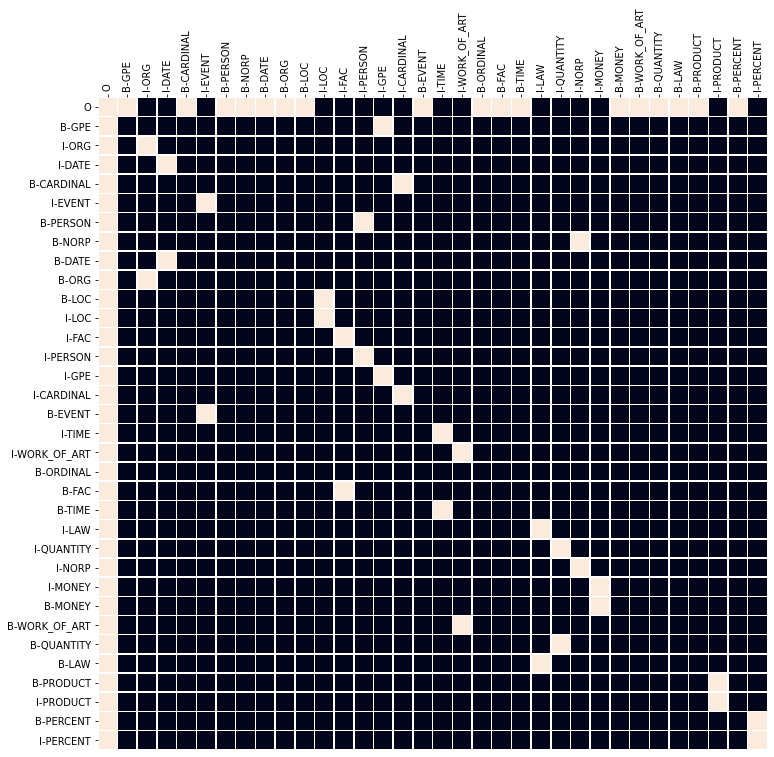

In [17]:
transition_dict=make_transitionmatrix()
#print(transition_dict)

In [18]:
def find_logits(s):
  tag_ids = model.forward_on_instance(s)['tag_logits']
  return tag_ids
logit_output = [find_logits(i) for i in validation_dataset]


In [19]:
def viterbi(true_tags, tag_names, start_logit, transition_prob, emission_logits):
    V = [{}]
    for st in tag_names:
        V[0][st] = {"sum_log": np.log(start_logit[st] + 10**(-80)) + emission_logits[st][true_tags[0]], "prev": None}
    # Run Viterbi when t > 0
    for t in range(1, len(true_tags)):
        V.append({})
        for st in tag_names:
            max_tr_prob = V[t - 1][tag_names[0]]["sum_log"] + transition_prob[tag_names[0]][st]
            prev_st_selected = tag_names[0]
            for prev_st in tag_names[1:]:
                tr_prob = V[t - 1][prev_st]["sum_log"] + transition_prob[prev_st][st]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st

            max_logsum = max_tr_prob + emission_logits[st][true_tags[t]]
            V[t][st] = {"sum_log": max_logsum, "prev": prev_st_selected}

    #for line in dptable(V):
        #print(line)

    opt = []
    max_logsum = 0.0
    best_st = None
    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["sum_log"] > max_logsum:
            max_logsum = data["sum_log"]
            best_st = st
    opt.append(best_st)
    previous = best_st

    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]

    #print ("The steps of tag_names are " + " ".join(opt) + " with sum log of %s" % max_logsum)
    return opt

def dptable(V):
    # Print a table of steps from dictionary
    yield " ".join(("%12d" % i) for i in range(len(V)))
    for state in V[0]:
        yield "%.7s: " % state + " ".join("%.7s" % ("%f" % v[state]["sum_log"]) for v in V)

In [21]:
def find_observations(example):
  true_tags=[]
  for i in word_gold_real[example]:
    true_tags.append(str(i[0]))
  return true_tags

def find_emission(example):
  dict_em={}
  for i in range(34):
    dict_em[tag_names[i]]={}
    for j in range(len(logit_output[example])):
      dict_em[tag_names[i]][str(word_gold_real[example][j][0])]=logit_output[example][j][i]
  return dict_em

#making the start probability, it's either 1 for valid start of "B" or "O" and it's 0 otherwise
start_logit={'O': 1, 'B-GPE': 1, 'I-ORG': 0, 'I-DATE': 0, 'B-CARDINAL': 1, 'I-EVENT': 0, 'B-PERSON': 1, 'B-NORP': 1, 'B-DATE': 1, 'B-ORG': 1, 'B-LOC': 1, 'I-LOC': 0, 'I-FAC': 0, 'I-PERSON': 0, 'I-GPE': 0, 'I-CARDINAL': 0, 'B-EVENT': 1, 'I-TIME': 0, 'I-WORK_OF_ART': 0, 'B-ORDINAL': 1, 'B-FAC': 1, 'B-TIME': 1, 'I-LAW': 0, 'I-QUANTITY': 0, 'I-NORP': 0, 'I-MONEY': 0, 'B-MONEY': 1, 'B-WORK_OF_ART': 1, 'B-QUANTITY': 1, 'B-LAW': 1, 'B-PRODUCT': 1, 'I-PRODUCT': 0, 'B-PERCENT': 1, 'I-PERCENT': 0}
#making the state array based on tag names
tag_names=[]
for key in start_logit:
  tag_names.append(key)


In [22]:
#running viterbi function on all validation examples and saving the answers in viterbi_answers
viterbi_answers=[]
for i in range(len(logit_output)):
  true_tags=find_observations(i)
  emission_logits=find_emission(i)
  viterbi_answers.append(viterbi(true_tags,tag_names,start_logit,transition_dict,emission_logits))

In [23]:
# Count the number of NER label violations on Viterbi output
def violations(tagged):
  count=0
  for i in range(len(tagged)):
    for j in range(len(tagged[i])):
      if j==0:
        if tagged[i][j]!='O' and tagged[i][j][0]!='B':
          count+=1
      if j+1<len(tagged[i]) and tagged[i][j]=='O' and tagged[i][j+1][0]=='I':
        count+=1
      elif j+1<len(tagged[i]) and tagged[i][j][0]=='B' and tagged[i][j+1][0]=='I' and tagged[i][j][1:]!=tagged[i][j+1][1:]:
        count+=1
      elif j+1<len(tagged[i]) and tagged[i][j][0]=='I' and tagged[i][j+1][0]=='I' and tagged[i][j][1:]!=tagged[i][j+1][1:]:
        count+=1
  return count

print('Number of violations in viterbi output is: ',violations(viterbi_answers))

Number of violations in viterbi output is:  0


In [26]:
#span-level precision, recall, and F1 for viterbi output and comparing by LSTM output
def span_stats(tagged,viterbi_output):
  predicted_output=[]
  true_output=[]
  viterbi_output=[]

  #making a continuous array from all predicted outputs in validation set
  for sample in tagged:
    for token in sample:
      predicted_output.append(token[2])
  
  for sample in viterbi_answers:
    for token in sample:
      viterbi_output.append(token)

  #making a continuous array from all true outputs in validation set
  for sample in validation_dataset:
      for i in sample['tags'].labels:
        true_output.append(i)

  print('True output in validation dataset')
  print(true_output)
  print('')
  print('Viterbi output')
  print(viterbi_output)
  print('')
  print('Predicted output by LSTM')
  print(predicted_output)

  print('\nLSTM precision: ',round(precision_score([true_output],[predicted_output]),3))
  print('LSTM recall: ',round(recall_score([true_output],[predicted_output]),3))
  print('LSTM F1: ',round(f1_score([true_output],[predicted_output]),3))


  print('\nViterbi precision: ',round(precision_score([true_output],[viterbi_output]),3))
  print('Viterbi recall: ',round(recall_score([true_output],[viterbi_output]),3))
  print('Viterbi F1: ',round(f1_score([true_output],[viterbi_output]),3))


span_stats(word_gold_real,viterbi_answers)

True output in validation dataset
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'B-TIME', 'I-TIME', 'O', 'B-PERSON', 'I-PERSON', 'B-ORDINAL', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CARDINAL', 'I-CARDINAL', 'I-CARDINAL', 'O', 'O', 'O', 'O', 'B-EVENT', 'I-EVENT', 'I-EVENT', 'I-EVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O